<a href="https://colab.research.google.com/gist/alejandro-ao/47db0b8b9d00b10a96ab42dd59d90b86/langchain-multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal RAG with LangChain

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [3]:
from unstructured.partition.pdf import partition_pdf

output_path = "./data/"
file_path = output_path + 'transformer.pdf'
# os.environ["UNSTRUCTURED_HI_RES_MODEL_NAME"] = "detectron2_onnx"
os.environ["UNSTRUCTURED_HI_RES_MODEL_NAME"] = "yolox"
# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

### Chunks and Elements 
Unstructured creates a set of chunks per documents. These chunks are in itself composed of multiple [elements and metadata ](https://docs.unstructured.io/api-reference/api-services/document-elements#document-elements-and-metadata). Elements could be Image, Text, Table, Formula, etc. 

In [4]:
# Number of instances for each elements, and seperate text, img and Tables
print(f'Number of Chunks {len(chunks)}')
chunk_type = set([str(type(el)) for el in chunks])
print(f'Type of chunk{chunk_type}')


# Collect Tables, Texts and Images -> fed to summerizer
tables = [] # as html
images = [] # as base64
texts = []  # str of a complete chunk

el_dict = {}
total_elements = 0

for cnt, ch in enumerate(chunks):
    texts.append(ch)
    for el in ch.metadata.orig_elements:
        total_elements += 1
        
        if el.category == 'Image':
            images.append(el.metadata.image_base64)
        elif el.category == 'Table':
            tables.append(el.metadata.text_as_html)
        else:
            pass
        
        if el.category not in el_dict.keys():
            el_dict[el.category] = {'count':1, 'eg':el.to_dict()}
        else:
            el_dict[el.category]['count'] += 1

for key, value in el_dict.items():
    print(f"Element Type {key}, Number of instance {value['count']}")

Number of Chunks 12
Type of chunk{"<class 'unstructured.documents.elements.CompositeElement'>"}
Element Type UncategorizedText, Number of instance 18
Element Type Header, Number of instance 3
Element Type Title, Number of instance 37
Element Type NarrativeText, Number of instance 84
Element Type Footer, Number of instance 8
Element Type Image, Number of instance 7
Element Type FigureCaption, Number of instance 5
Element Type Formula, Number of instance 5
Element Type ListItem, Number of instance 43
Element Type Table, Number of instance 4


In [5]:
# Print a chunk
print(chunks[0])

2023

3

2

0

2 g u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0 7 1

:

arXiv:

v

i

X

r

a

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

Noam Shazeer∗

Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗

Google Research usz@google.com

Llion Jones∗

Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡

illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Tra

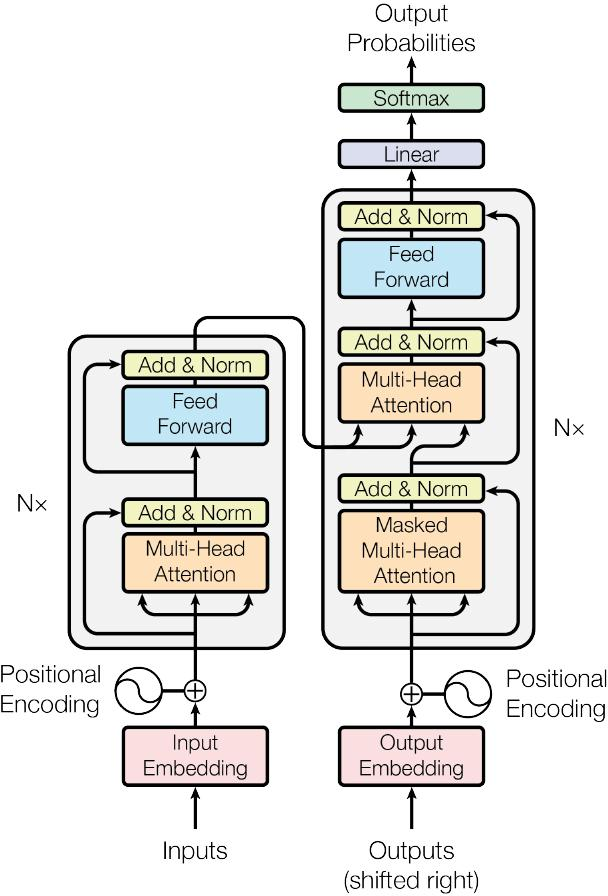

{'type': 'Image',
 'element_id': '1510009b-ebbe-4b8b-8043-88e107512f01',
 'text': 'Output Probabilities Add & Norm Feed Forward Add & Norm Multi-Head Attention yo Add & Norm Add & Norm Feed Forward Nx | Cag Norm) Add & Norm Masked Multi-Head Multi-Head Attention Attention Lt Lt Positional Positional Encoding EQ © OY Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)',
 'metadata': {'coordinates': {'points': ((545.9972222222221,
     200.00555555555542),
    (545.9972222222221, 1095.6055555555556),
    (1153.997222222222, 1095.6055555555556),
    (1153.997222222222, 200.00555555555542)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2024-11-24T09:27:23',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 3,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjI

In [20]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))


display_base64_image(el_dict['Image']['eg']['metadata']['image_base64'])
el_dict['Image']['eg']

In [7]:
# Display Tables
from IPython.display import HTML, display

display(HTML(el_dict['Table']['eg']['metadata']['text_as_html']))
el_dict['Table']['eg']


Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
Self-Attention,O(n? - d),O(1),O(1)
Recurrent,O(n - d?),O(n),O(n)
Convolutional,O(k-n-d?),O(1),O(logx(n))
Self-Attention (restricted),O(r-n-d),ol),O(n/r)


{'type': 'Table',
 'element_id': 'f1ef95b9-d82b-40a2-ac76-12a2b73cd885',
 'text': 'Layer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)',
 'metadata': {'detection_class_prob': 0.928255021572113,
  'coordinates': {'points': ((320.3291931152344, 312.45477294921875),
    (320.3291931152344, 519.1640014648438),
    (1363.98291015625, 519.1640014648438),
    (1363.98291015625, 312.45477294921875)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2024-11-24T09:27:23',
  'text_as_html': '<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n? - d)</td><td>O(1)</td><td>O(1)</td></tr><tr><td>Recurrent</td><td>O(n - d?)</td><td>O(n)</td><td>O(n

### overlay chunks on pdf 
Code used from [LangChain documentation](https://python.langchain.com/docs/how_to/document_loader_pdf/)

In [43]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import PIL.Image 
from langchain.schema.document import Document


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = PIL.Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()
    
    return None


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

    return None
            
def extract_page_no(chunk):
    elements = chunk.metadata.orig_elements
    page_numbers = set()
    
    for el in elements:
        page_numbers.add(el.metadata.page_number)
    
    return page_numbers

def display_chunk(chunk):
    page_numbers = extract_page_no(chunk)
    print(f'Page numbers{page_numbers}')
    
    docs = []
    for element in chunk.metadata.orig_elements:
        metadata = element.metadata.to_dict()
        if element.category == 'Image':
            metadata['category'] = 'Image'
        elif element.category == 'Table':
            metadata['category'] = 'Table'
        else:
            metadata['category'] = 'Text'
        metadata['page_number'] = int(element.metadata.page_number)
        
        docs.append(Document(page_content=element.text, metadata=metadata))
    
    for page_number in page_numbers:
        render_page(docs, page_number, False)
    
    return None

Page numbers{5, 6}


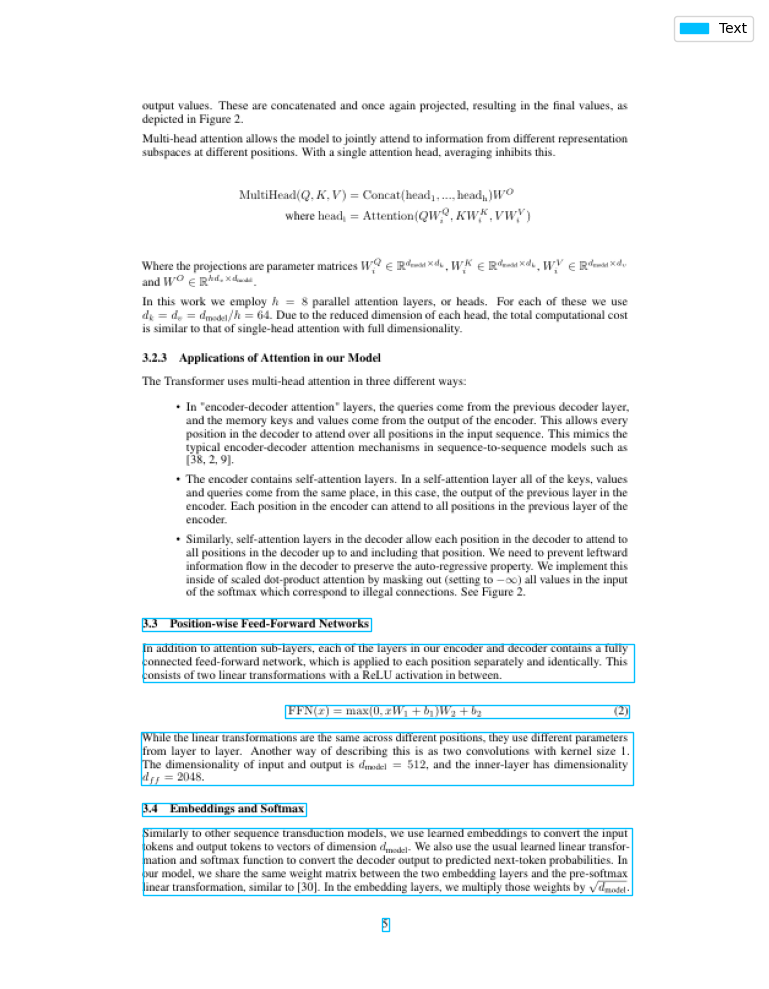

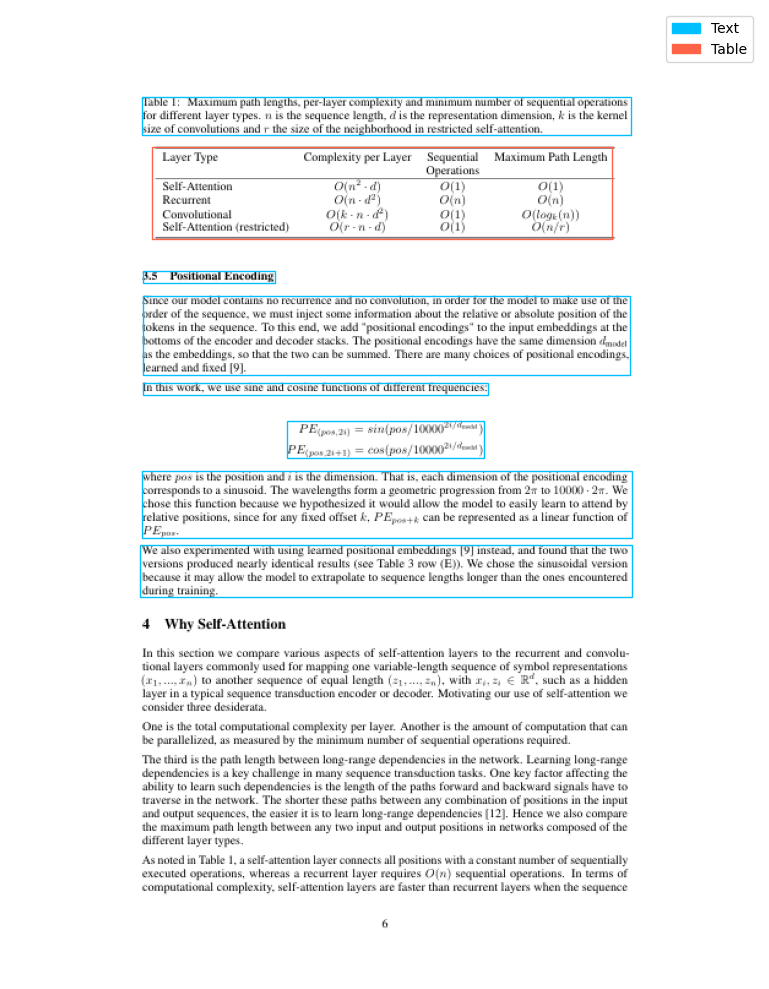

In [9]:
display_chunk(chunks[5])

### Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

In [10]:
# from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [11]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0.5, model="gpt-4o-mini")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [12]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 3})

In [30]:
display(HTML(tables[0]))
print((table_summaries[0]))


Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
Self-Attention,O(n? - d),O(1),O(1)
Recurrent,O(n - d?),O(n),O(n)
Convolutional,O(k-n-d?),O(1),O(logx(n))
Self-Attention (restricted),O(r-n-d),ol),O(n/r)


The table compares four layer types in terms of complexity per layer, sequential operations, and maximum path length. Self-Attention has a complexity of O(n? - d), with O(1) sequential operations and a maximum path length of O(1). Recurrent layers have a complexity of O(n - d?), O(n) sequential operations, and a maximum path length of O(n). Convolutional layers show a complexity of O(k-n-d?), with O(1) sequential operations and a maximum path length of O(logx(n)). Restricted Self-Attention has a complexity of O(r-n-d), unspecified sequential operations, and a maximum path length of O(n/r).


In [31]:
text_summaries[0]

'The paper introduces the Transformer, a novel network architecture that relies solely on attention mechanisms, eliminating the need for recurrent or convolutional neural networks. It demonstrates superior performance in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, outperforming existing models while being more efficient in training time. The Transformer also shows versatility by successfully applying to English constituency parsing. The authors contributed equally and include researchers from Google Brain, Google Research, and the University of Toronto.'

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [15]:
from langchain_openai import ChatOpenAI

# Here we are alredy provifing the contect for the LLM (how to handel this automatically)
prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()

image_summaries = chain.batch(images)

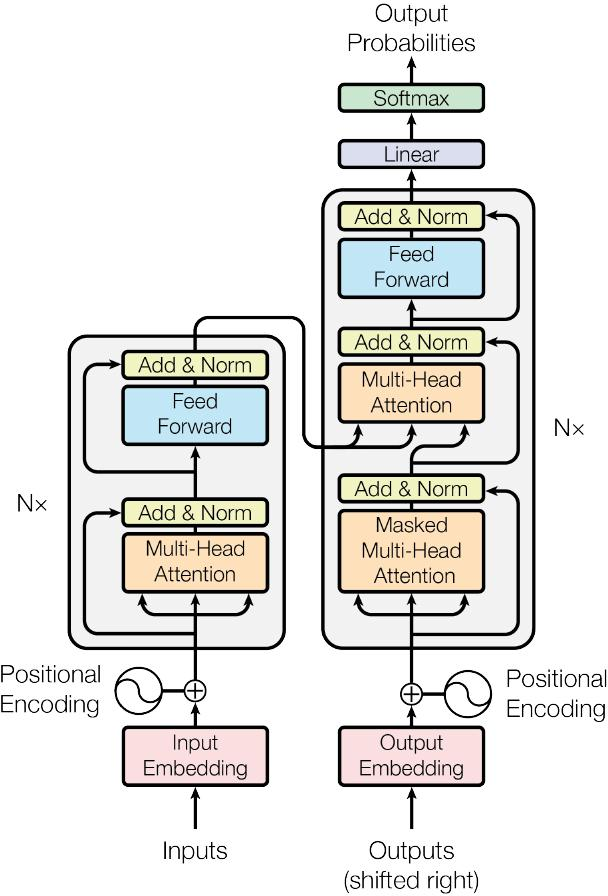

The image represents a detailed architecture of the Transformer model, commonly used in natural language processing tasks. Here's a breakdown of its components:

1. **Input and Output Embeddings**:
   - At the bottom of the diagram, there are two blocks labeled "Input Embedding" and "Output Embedding." These represent the initial representations of the input tokens and the shifted output tokens, respectively.

2. **Positional Encoding**:
   - Above the input and output embeddings, there are circles indicating "Positional Encoding." This is crucial for providing information about the position of tokens in the sequence.

3. **Encoder and Decoder Structure**:
   - The diagram is divided into two main sections: the encoder (left) and the decoder (right). Each section has a series of blocks stacked vertically, indicating multiple layers (denoted as \(N_x\)).

4. **Encoder Blocks**:
   - Each encoder block contains:
     - **Multi-Head Attention**: This processes input embeddings, allowing t

In [22]:
display_base64_image(images[0])
print(image_summaries[0])


## Load data and summaries to vectorstore

### Create the vectorstore

In [34]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
# from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

### Load the summaries and link the to the original data

In [35]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [36]:
# Retrieve
docs = retriever.invoke(
    # "who are the authors of the paper?"
    "what is multi head attention?"
)

In [41]:
docs

 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHYA4UDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0KHxFq3ifxxrmhaVqMGmW2iiJZHMAlluJHBJwGOFRcY6ZOeorS8O3/iQeKdV0nxA1nJFDbwy2U9rEYxKpZw5YFjhuFBGcDt1rnfGfw4vr7XT4v8F6t/Z2v7cSLn91c4GMHqAcAA5BBwM461N4F+JFxrI1XS/EenGw8QaPE0

In [38]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

3.2.2 Multi-Head Attention

Instead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional

‘To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, g -k = ves, qiki, has mean 0 and variance dx.

4

output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

MultiHead(Q, K, V ) = Concat(head

Page numbers{12, 13, 14, 15}


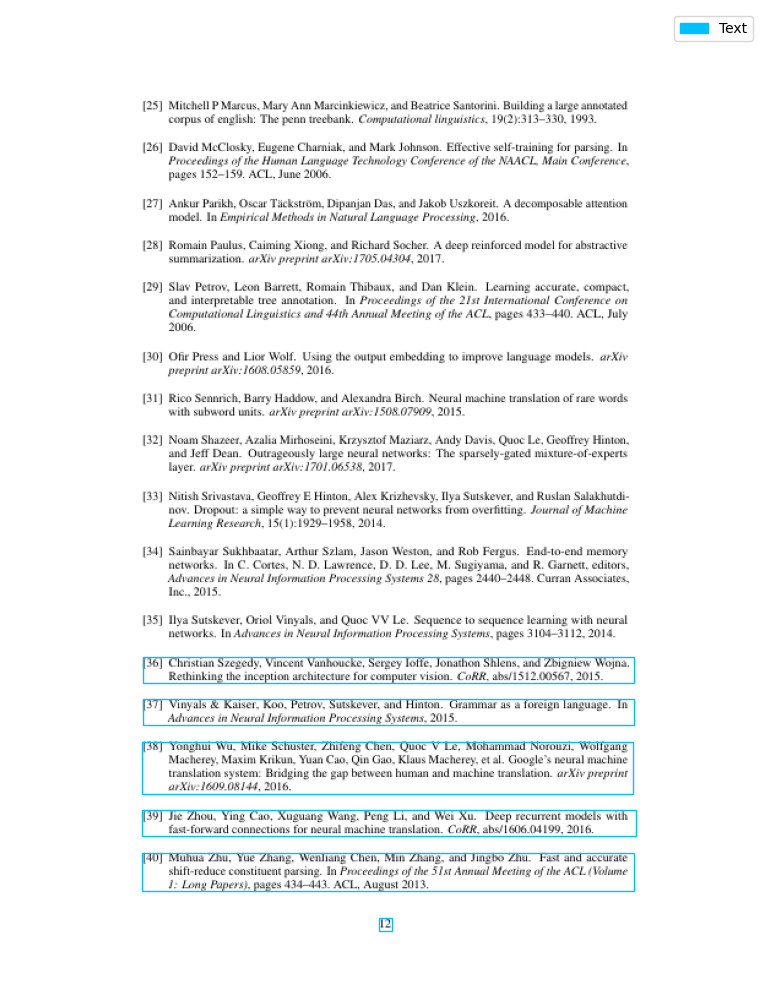

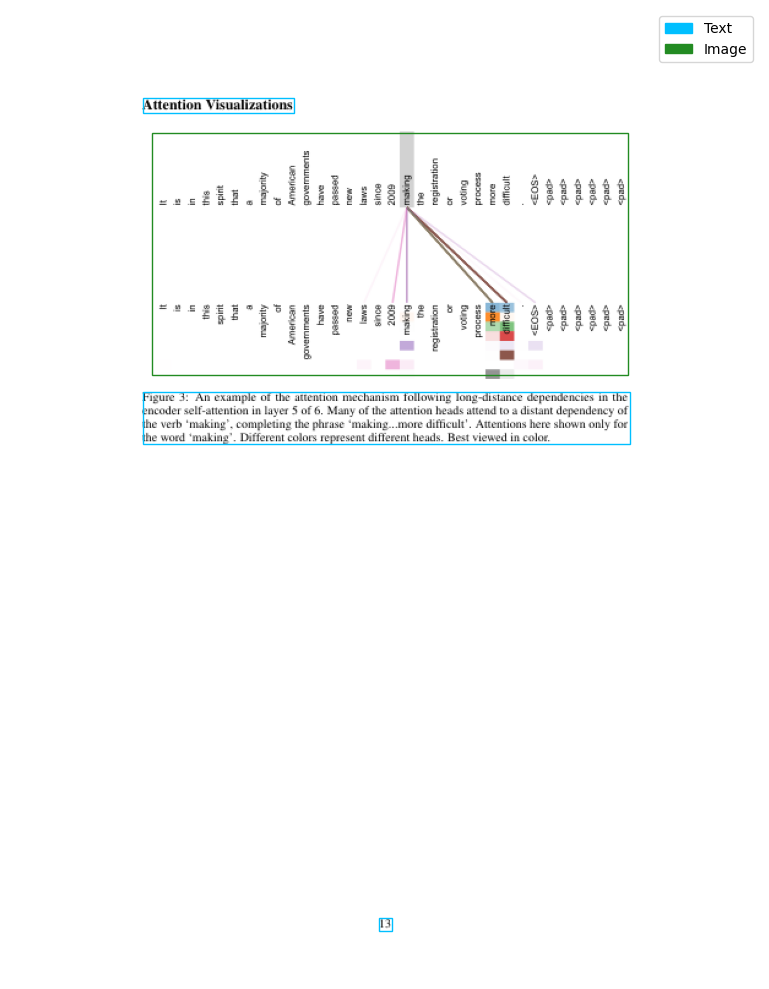

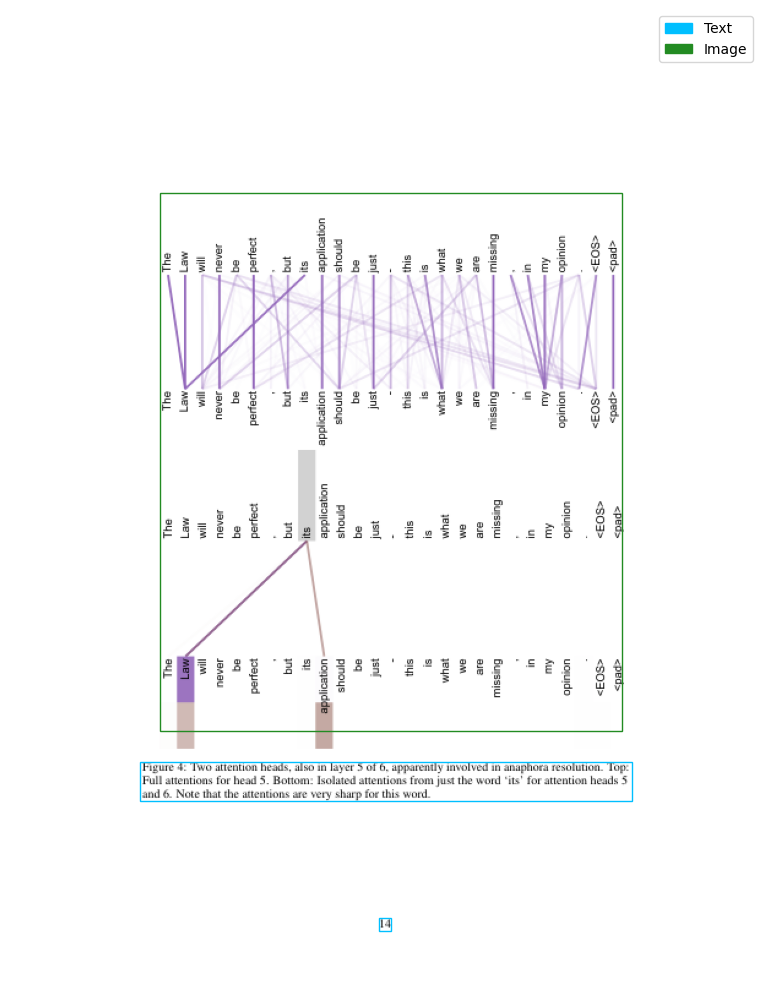

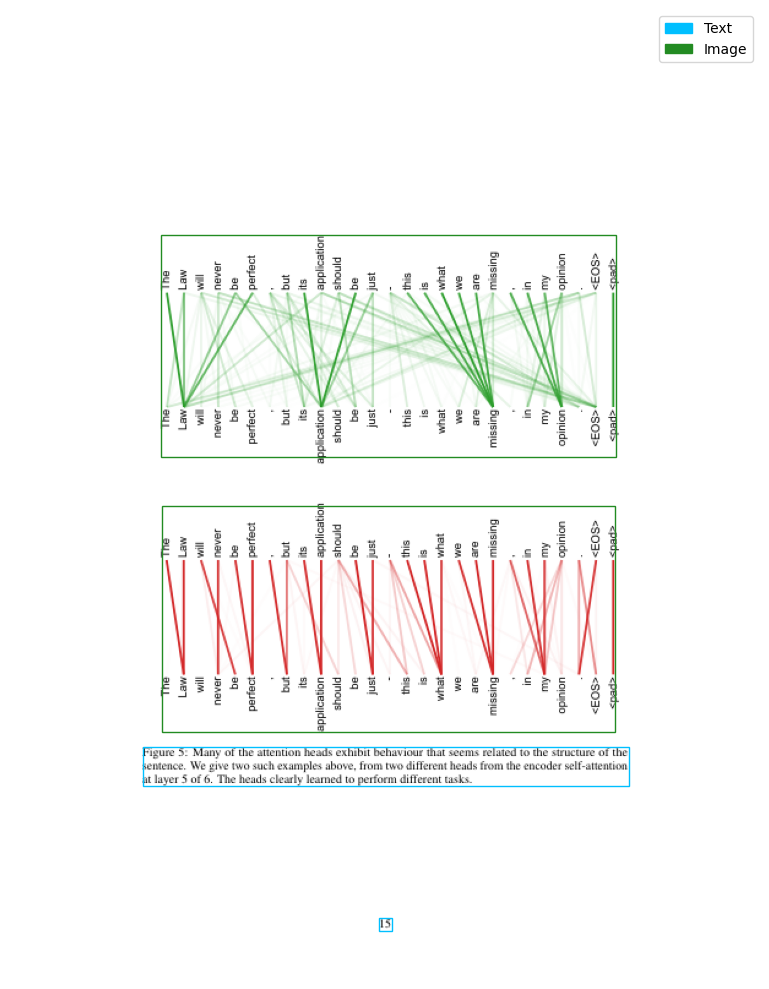

In [46]:
# display chunks
display_chunk(docs[2])

## RAG pipeline

In [47]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text, "chunks": docs}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [48]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a process that allows a model to focus on different parts of the input sequence when producing an output. In the context of multi-head attention, it involves creating multiple attention heads that can jointly attend to information from different representation subspaces at various positions.

Each attention head computes a weighted representation of the input, where the weights are determined by the relevance of other words in the sequence, allowing the model to capture long-range dependencies and relationships between words. This mechanism enables the model to efficiently process sequences by considering the context provided by all positions in the input. 

In practice, the attention values are computed using queries, keys, and values, which are derived from the input through learned linear projections. The final output is a concatenation of the outputs from all attention heads, followed by another linear transformation. This approach helps preserve rich con

In [51]:
response = chain.invoke(
    "What is the contribution of this paper?"
)

print(response)

The contribution of this paper is the introduction of the Transformer architecture, which is solely based on attention mechanisms, eliminating the need for recurrence and convolutions. This architecture demonstrates superior performance in machine translation tasks compared to traditional recurrent and convolutional models. Specifically, the Transformer achieves state-of-the-art BLEU scores on English-to-German and English-to-French translation tasks, showing enhanced parallelizability and reduced training time. Additionally, it generalizes well to other tasks, such as English constituency parsing, outperforming existing models even without task-specific tuning.


Response: Multi-head attention is an extension of the traditional attention mechanism that allows a model to jointly attend to information from different representation subspaces at various positions. Instead of using a single attention function, multi-head attention employs multiple attention heads, each performing attention in parallel. 

In this approach, the queries, keys, and values are linearly projected multiple times using learned projections into lower-dimensional spaces. Each head computes attention independently, and the resulting output values from all heads are concatenated and then projected back to the original dimensionality. This method enhances the model's ability to capture diverse patterns and relationships in the input data, resulting in richer feature representations. 

In the context of the Transformer model, multi-head attention is crucial for both encoder-decoder attention and self-attention mechanisms, allowing for more complex interactions and dependencies in

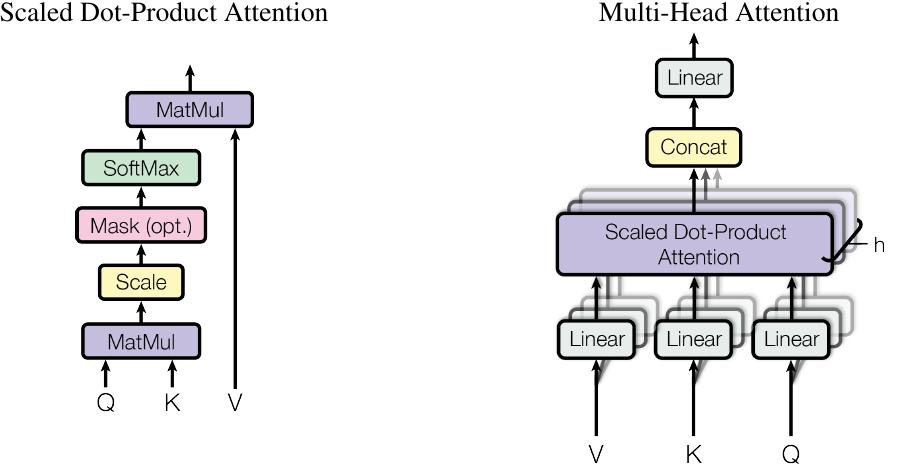

In [52]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)